## Importar librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import geopandas as gpd
from datetime import datetime
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

## Configuracion Inicial

In [2]:
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

## Carga y Exploracion Inicial

In [3]:
df = pd.read_csv('../data/egresos_resources_final.csv')

# Información básica del dataset
print(f"Dimensiones: {df.shape}")
print(f"\nPrimeras filas:\n{df.head()}")
print(f"\nInformacion:\n{df.info()}")
print(f"\nEstadísticas descriptivas categoricas:\n{df.describe(include='all')}")

Dimensiones: (243562, 52)

Primeras filas:
   clave_entidad  clave_municipio  clave_localidad nombre_entidad  \
0             11                7                1     Guanajuato   
1             11                7                1     Guanajuato   
2             11                7                1     Guanajuato   
3             11                7                1     Guanajuato   
4             11                7                1     Guanajuato   

  nombre_municipio nombre_localidad  lat_decimal  lon_decimal    sexo  \
0           Celaya           Celaya    20.521523  -100.813573  hombre   
1           Celaya           Celaya    20.521523  -100.813573  hombre   
2           Celaya           Celaya    20.521523  -100.813573  hombre   
3           Celaya           Celaya    20.521523  -100.813573   mujer   
4           Celaya           Celaya    20.521523  -100.813573  hombre   

   servicio_troncal fecha_ingreso fecha_egreso diagnostico_principal_cie10  \
0         Pediatria    20

## Conversion de Tipo de Datos de Fechas

In [4]:
# Conversión de fechas a datetime
df['fecha_ingreso'] = pd.to_datetime(df['fecha_ingreso'], errors='coerce')
df['fecha_egreso'] = pd.to_datetime(df['fecha_egreso'], errors='coerce')

# Eliminar filas con fechas inválidas
df.dropna(subset=['fecha_ingreso', 'fecha_egreso'], inplace=True)

print("Carga y conversión de fechas completada.")
print(f"Dataset cargado con {df.shape[0]} filas y {df.shape[1]} columnas.")
display(df.head())

Carga y conversión de fechas completada.
Dataset cargado con 243562 filas y 52 columnas.


,clave_entidad,clave_municipio,clave_localidad,nombre_entidad,nombre_municipio,nombre_localidad,lat_decimal,lon_decimal,sexo,servicio_troncal,fecha_ingreso,fecha_egreso,diagnostico_principal_cie10,descripcion_diagnostico,clues,codigo_postal,nivel_atencion,personal_medico_general,personal_medico_esp,ginecoobstetras,pediatras,cirujanos,internistas,anestesiologos,odontologos,pasantes,personal_hospital,enfermeras_general,enfermeras_esp,atencion_medica,camas_hospitalizacion,camas_atencion_temporal,labs,infraestructura_imagenologia,infraestructura_radioterapia,infraestructura_quirurgica_obstetrica,infraestructura_neonatal_pediatrica,infraestructura_uci,infraestructura_urgencias_aislamiento,infraestructura_diagnostico_funcional,infraestructura_dialisis,infraestructura_banco_sangre,infraestructura_odontologia,edad,year_ingreso,mes_ingreso,dia_sem_ingreso,trimestre_ingreso,year_egreso,mes_egreso,dia_sem_egreso,trimestre_egreso
0,11,7,1,Guanajuato,Celaya,Celaya,20.521523,-100.813573,hombre,Pediatria,2024-01-26,2024-01-28,A09.9,Gastroenteritis y colitis de origen no especif...,GTIST000045,38020,SEGUNDO NIVEL,912,530,48,35,44,32,33,11,3,1947,380,32,65,536,168,11,78,2,51,115,64,45,32,28,5,2,5 a 11 años,2024,1,5,1,2024,1,7,1
1,11,7,1,Guanajuato,Celaya,Celaya,20.521523,-100.813573,hombre,Cirugia General,2024-01-22,2024-01-25,K60.3,Fistula anal,GTIST000045,38020,SEGUNDO NIVEL,912,530,48,35,44,32,33,11,3,1947,380,32,65,536,168,11,78,2,51,115,64,45,32,28,5,2,45 a 59 años,2024,1,1,1,2024,1,4,1
2,11,7,1,Guanajuato,Celaya,Celaya,20.521523,-100.813573,hombre,Cirugia General,2024-01-26,2024-01-26,J34.2,Desviacion del tabique nasal,GTIST000045,38020,SEGUNDO NIVEL,912,530,48,35,44,32,33,11,3,1947,380,32,65,536,168,11,78,2,51,115,64,45,32,28,5,2,60 a 74 años,2024,1,5,1,2024,1,5,1
3,11,7,1,Guanajuato,Celaya,Celaya,20.521523,-100.813573,mujer,Cirugia General,2024-01-30,2024-01-30,J34.2,Desviacion del tabique nasal,GTIST000045,38020,SEGUNDO NIVEL,912,530,48,35,44,32,33,11,3,1947,380,32,65,536,168,11,78,2,51,115,64,45,32,28,5,2,30 a 44 años,2024,1,2,1,2024,1,2,1
4,11,7,1,Guanajuato,Celaya,Celaya,20.521523,-100.813573,hombre,Medicina Interna,2024-01-01,2024-01-07,K25.0,úlcera gastrica aguda con hemorragia,GTIST000045,38020,SEGUNDO NIVEL,912,530,48,35,44,32,33,11,3,1947,380,32,65,536,168,11,78,2,51,115,64,45,32,28,5,2,75 a 89 años,2024,1,1,1,2024,1,7,1


### 1. Análisis #1: Ocupación Real de Camas

Hipótesis: 
La ocupación de camas exhibe una fuerte y predecible estacionalidad, con una fluctuación operativa de aproximadamente 500 camas a lo largo del año. La demanda base en los valles de verano (junio-julio) se sitúa en torno a las 3,100 camas, mientras que los picos invernales (diciembre-enero) exigen una capacidad máxima que se acerca a las 3,600 camas, definiendo el rango de variabilidad que el modelo debe predecir.

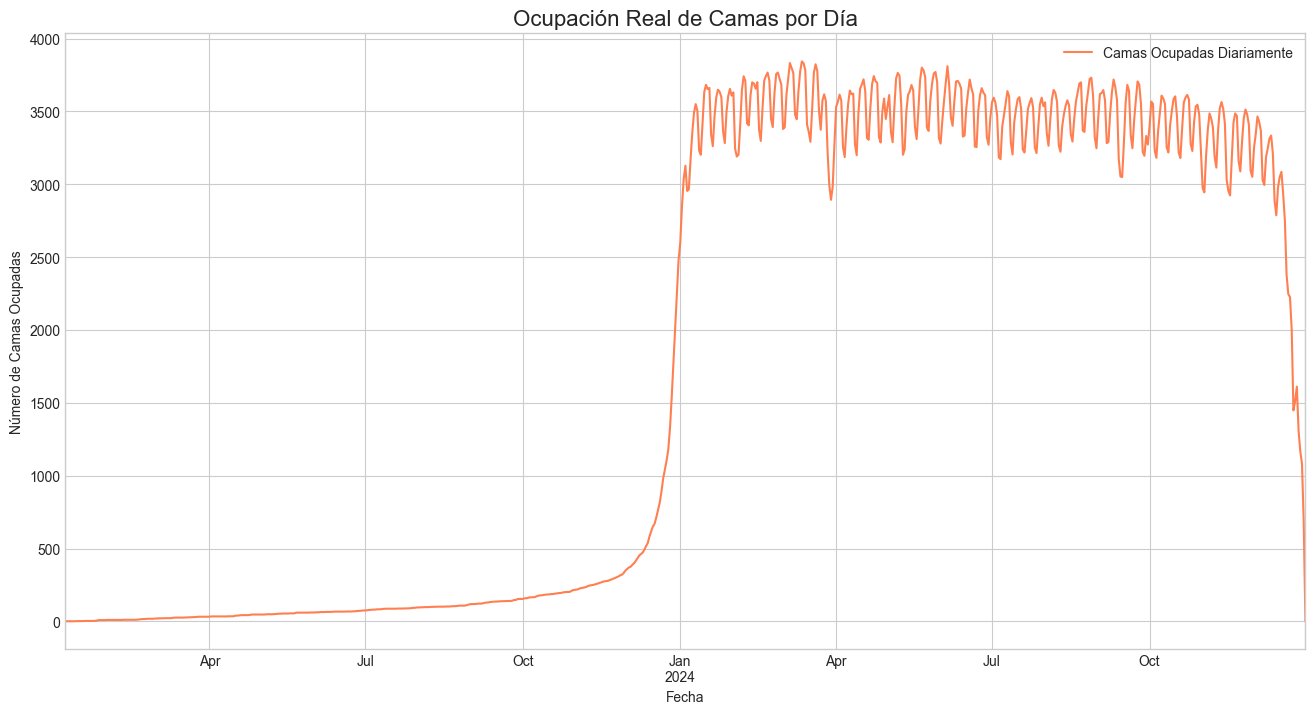

In [5]:
date_range = pd.date_range(start=df['fecha_ingreso'].min(), end=df['fecha_egreso'].max(), freq='D')
ocupacion_diaria = [
    df[(df['fecha_ingreso'] <= dia) & (df['fecha_egreso'] > dia)].shape[0]
    for dia in date_range
]
serie_ocupacion = pd.Series(ocupacion_diaria, index=date_range)

serie_ocupacion.plot(figsize=(16, 8), color='coral', label='Camas Ocupadas Diariamente')
plt.title('Ocupación Real de Camas por Día', fontsize=16)
plt.ylabel('Número de Camas Ocupadas')
plt.xlabel('Fecha')
plt.legend()
plt.grid(True)
plt.show()

### Análisis #2: Flujo de Demanda Diaria

Hipótesis:
El flujo de admisiones diarias es extremadamente volátil y carece de una línea base clara, con una fluctuación operativa que oscila agresivamente entre 400 y 800 ingresos diarios. Esto permite ver que un modelo simple basado en promedios no sera muy efectivo.

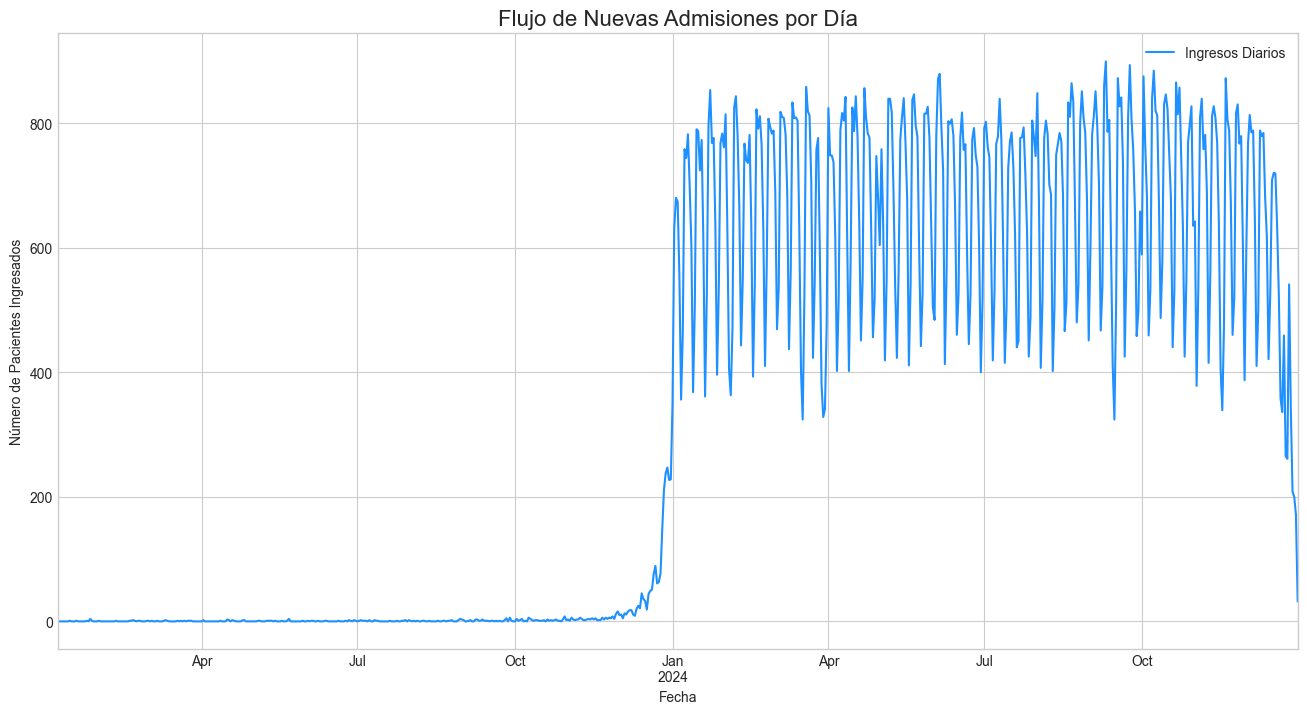

In [27]:
ingresos_diarios = df.set_index('fecha_ingreso').resample('D').size()

ingresos_diarios.plot(figsize=(16, 8), color='dodgerblue', label='Ingresos Diarios')
plt.title('Flujo de Nuevas Admisiones por Día', fontsize=16)
plt.ylabel('Número de Pacientes Ingresados')
plt.xlabel('Fecha')
plt.legend()
plt.grid(True)
plt.show()

### Análisis #3: Carga de Pacientes por Nivel de Atención Hospitalaria


Hipótesis:
La carga de trabajo se correlaciona directamente con la especialización del hospital. Los hospitales de TERCER NIVEL manejan la mayor carga, con un promedio de un aproximado de 20 ingresos diarios por hospital. Esta carga disminuye drásticamente en los de SEGUNDO NIVEL (aproximadamente 5 ingresos al día) y es mínima en los de PRIMER NIVEL (aproximadamente 1 ingreso al día). El modelo deberá usar nivel_atencion como una feature categórica de alta importancia si se desagrega por hospital.

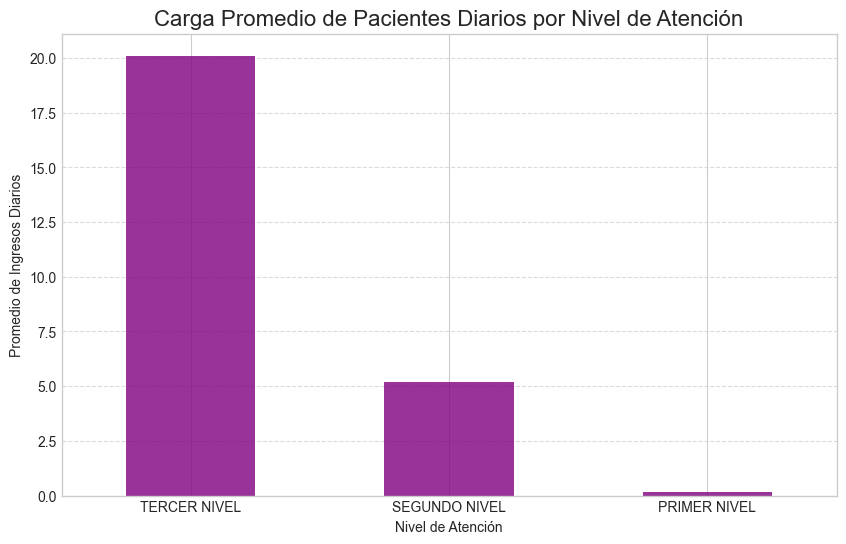

In [28]:
avg_ingresos_por_hospital = df.groupby('clues').apply(lambda x: x.set_index('fecha_ingreso').resample('D').size().mean()).rename('avg_ingresos_diarios')
nivel_atencion_por_hospital = df.drop_duplicates(subset='clues').set_index('clues')['nivel_atencion']
df_capacidad = pd.DataFrame(avg_ingresos_por_hospital).join(nivel_atencion_por_hospital)

carga_por_nivel = df_capacidad.groupby('nivel_atencion')['avg_ingresos_diarios'].mean().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
carga_por_nivel.plot(kind='bar', color='purple', alpha=0.8)
plt.title('Carga Promedio de Pacientes Diarios por Nivel de Atención', fontsize=16)
plt.xlabel('Nivel de Atención')
plt.ylabel('Promedio de Ingresos Diarios')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Análisis #4: Composición de la Demanda

Hipótesis:
La demanda de los principales servicios no es independiente; sigue un patrón estacional sincronizado, con picos y valles que ocurren en las mismas fechas para todos. Esto sugiere que un factor macro (como la temporada de influenza) impacta a todo el hospital simultáneamente, en lugar de a servicios aislados.

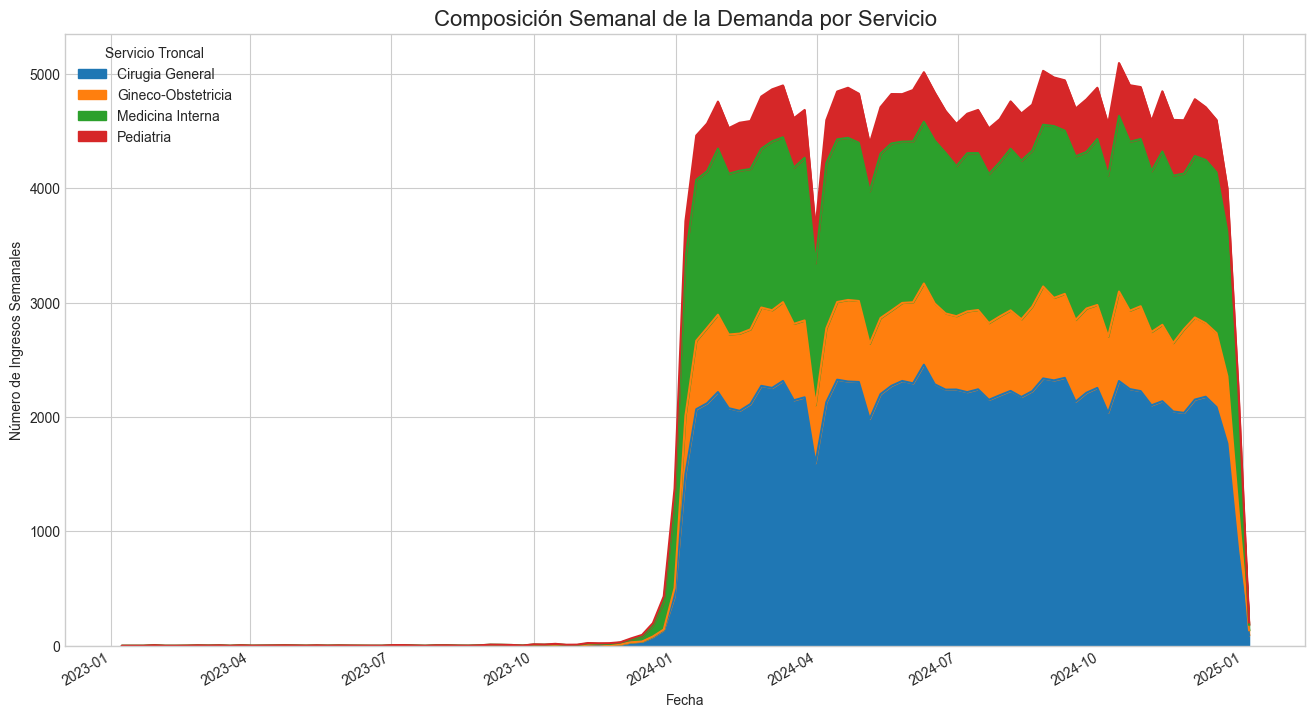

In [33]:
top_servicios = df['servicio_troncal'].value_counts().nlargest(5).index
df_servicios_pivot = df[df['servicio_troncal'].isin(top_servicios)].pivot_table(
    index=pd.Grouper(key='fecha_ingreso', freq='W'),
    columns='servicio_troncal',
    values='sexo', # Contamos cualquier columna no nula
    aggfunc='count'
)

df_servicios_pivot.plot(kind='area', stacked=True, figsize=(16, 9))
plt.title('Composición Semanal de la Demanda por Servicio', fontsize=16)
plt.ylabel('Número de Ingresos Semanales')
plt.xlabel('Fecha')
plt.legend(title='Servicio Troncal')
plt.show()

### Análisis #5: Patrones Temporales de Demanda

Hipótesis:
La demanda tiene un componente cíclico semanal y mensual fuerte. Semanalmente, la mediana de ingresos cae por debajo de 250 ingresos/día durante el fin de semana. Mensualmente, la mediana de ingresos es notablemente más alta en los meses de invierno (enero-febrero), superando los 350 ingresos, en comparación con los meses de verano.

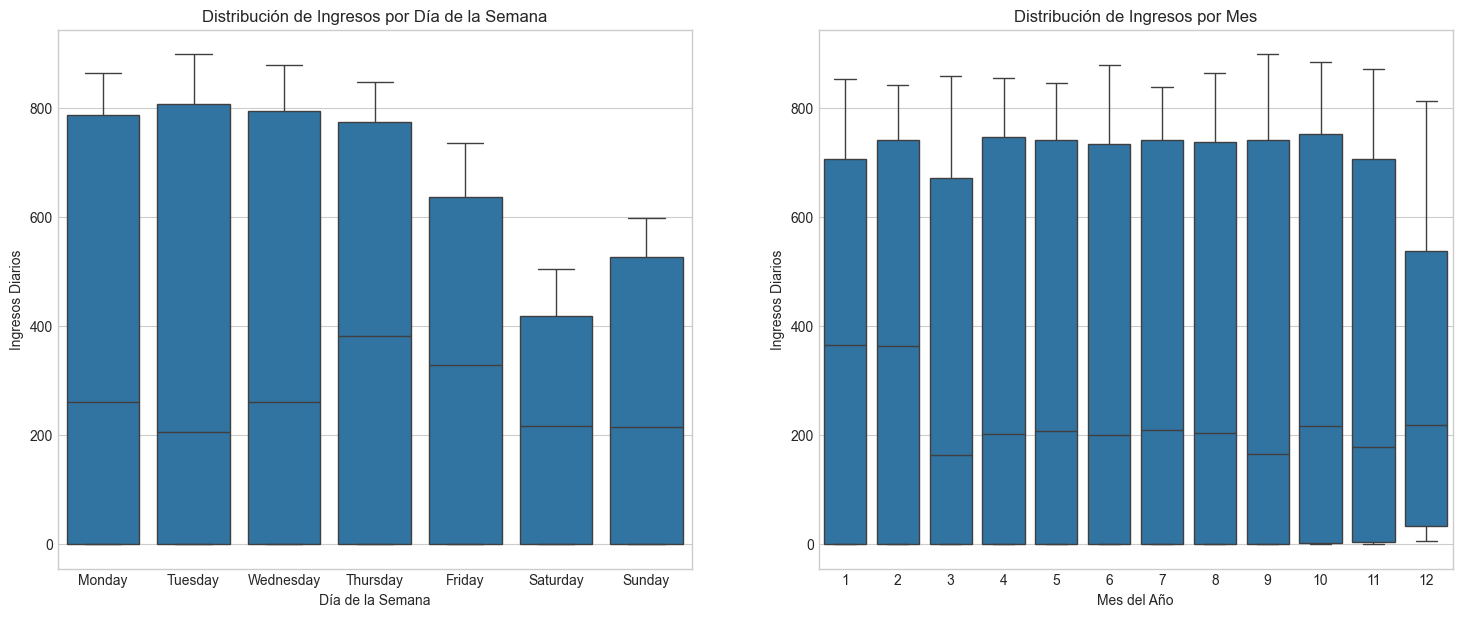

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
dias_ordenados = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

sns.boxplot(x=ingresos_diarios.index.day_name(), y=ingresos_diarios.values, ax=ax1, order=dias_ordenados) # type: ignore
ax1.set_title('Distribución de Ingresos por Día de la Semana')
ax1.set_xlabel('Día de la Semana')
ax1.set_ylabel('Ingresos Diarios')

sns.boxplot(x=ingresos_diarios.index.month, y=ingresos_diarios.values, ax=ax2) # type: ignore
ax2.set_title('Distribución de Ingresos por Mes')
ax2.set_xlabel('Mes del Año')
ax2.set_ylabel('Ingresos Diarios')
plt.show()

### Análisis #6: Perfil de Estancia y Diagnósticos de Larga Duración

El consumo de camas depende críticamente del servicio, con medianas de estancia que van desde solo 2 días (Gineco-Obstetricia, Cirugia General y Pediatria) hasta 5 días (Medicina Interna). Adicionalmente, las estancias outlier en los servicios de mayor duración son impulsadas por diagnósticos específicos, los cuales consumen una cantidad desproporcionada de recursos.

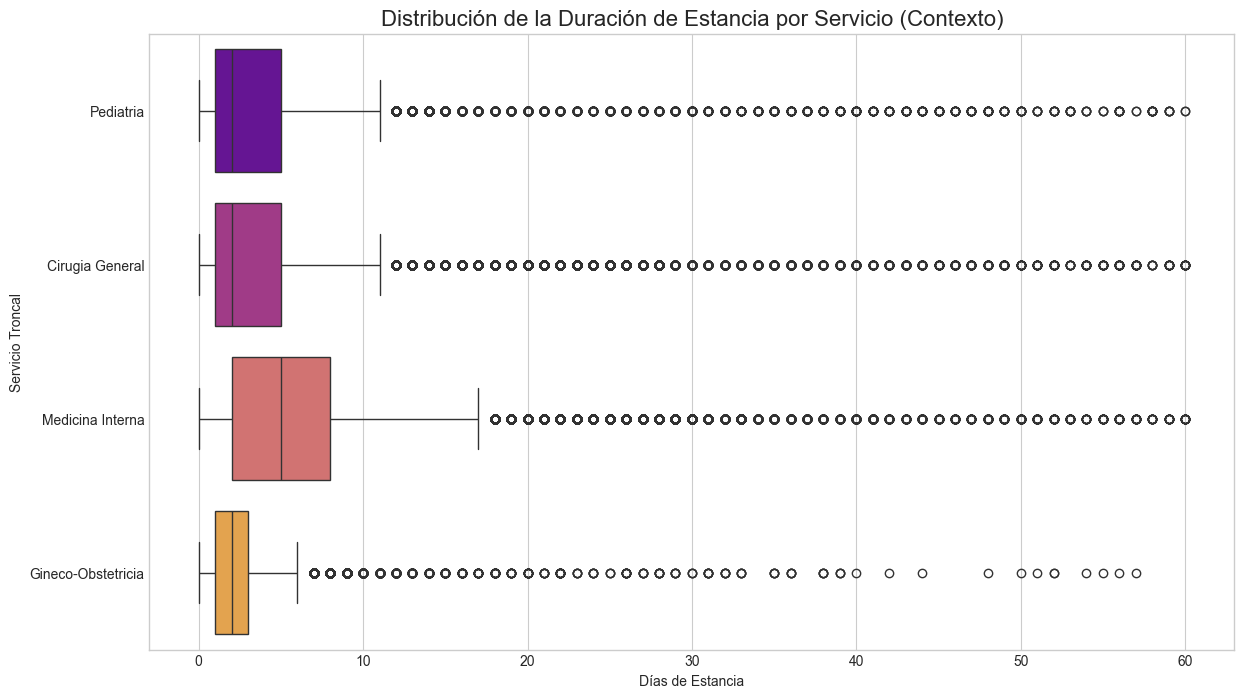


Sub-Análisis: Top Diagnósticos que causan estancias outlier en cada servicio:


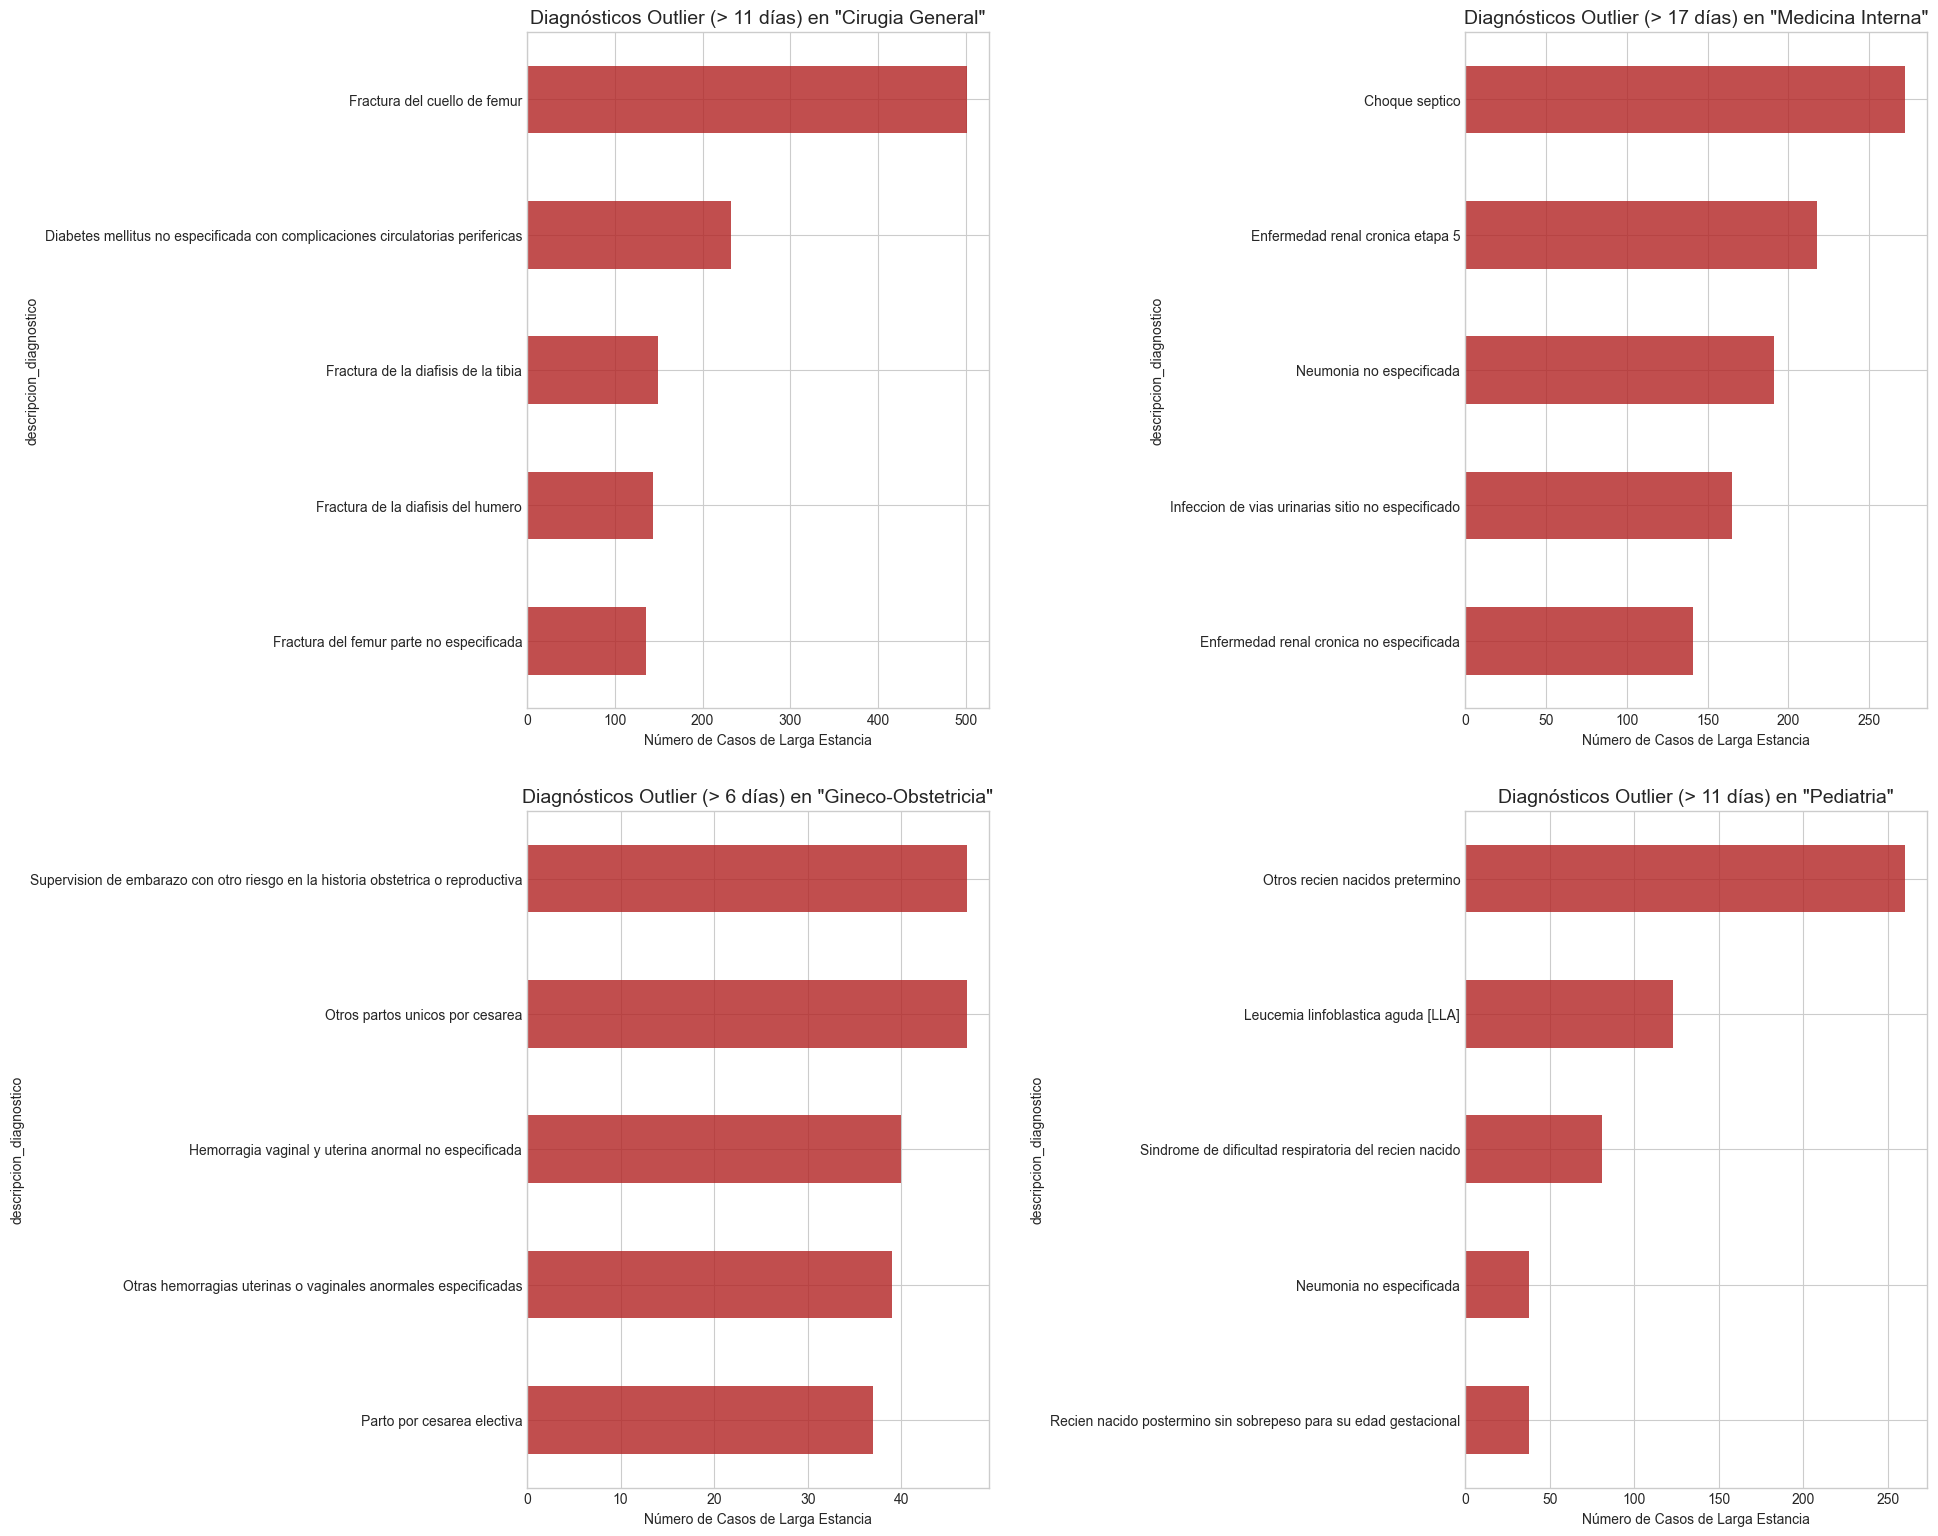

In [ ]:
df['duracion_estancia'] = (df['fecha_egreso'] - df['fecha_ingreso']).dt.days
df_estancia_filtrada = df[(df['duracion_estancia'] >= 0) & (df['duracion_estancia'] <= 60)]
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_estancia_filtrada[df_estancia_filtrada['servicio_troncal'].isin(top_servicios)],
            x='duracion_estancia', y='servicio_troncal', palette='plasma')
plt.title('Distribución de la Duración de Estancia por Servicio (Contexto)', fontsize=16)
plt.xlabel('Días de Estancia')
plt.ylabel('Servicio Troncal')
plt.show()

# --- Sub-Análisis con Umbrales Dinámicos ---
print("\nSub-Análisis: Top Diagnósticos que causan estancias outlier en cada servicio:")

top_4_servicios = df_estancia_filtrada['servicio_troncal'].value_counts().nlargest(4).index

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
axes = axes.flatten()

for i, servicio in enumerate(top_4_servicios):
    ax = axes[i]
    df_servicio_filtrado = df_estancia_filtrada[df_estancia_filtrada['servicio_troncal'] == servicio]
    
    # 1. Calcular el umbral de outlier específico para ESTE servicio (Método IQR)
    Q1 = df_servicio_filtrado['duracion_estancia'].quantile(0.25)
    Q3 = df_servicio_filtrado['duracion_estancia'].quantile(0.75)
    IQR = Q3 - Q1
    umbral_outlier = Q3 + 1.5 * IQR
    
    # 2. Filtrar los outliers para ESE servicio usando su umbral dinámico
    df_outliers_servicio = df_servicio_filtrado[df_servicio_filtrado['duracion_estancia'] > umbral_outlier]
    
    # 3. Obtener los diagnósticos más comunes de ESOS outliers
    top_diagnosticos = df_outliers_servicio['descripcion_diagnostico'].value_counts().nlargest(5)
    
    top_diagnosticos.plot(kind='barh', ax=ax, color='firebrick', alpha=0.8)
    ax.set_title(f'Diagnósticos Outlier (> {umbral_outlier:.0f} días) en "{servicio}"', fontsize=14)
    ax.set_xlabel('Número de Casos de Larga Estancia')
    ax.invert_yaxis()

plt.tight_layout(pad=3.0)
plt.show()

### Análisis #7: Visualización Geográfica de las clinicas por entidades

Hipótesis:
La demanda hospitalaria está geográficamente concentrada. Las 3 entidades principales (Ciudad de Mexico, Michoacan y Puebla) representan la mayor carga de trabajo y forman grupos de alta demanda que requerirán un enfoque de modelado regional para capturar sus demandas específicas.

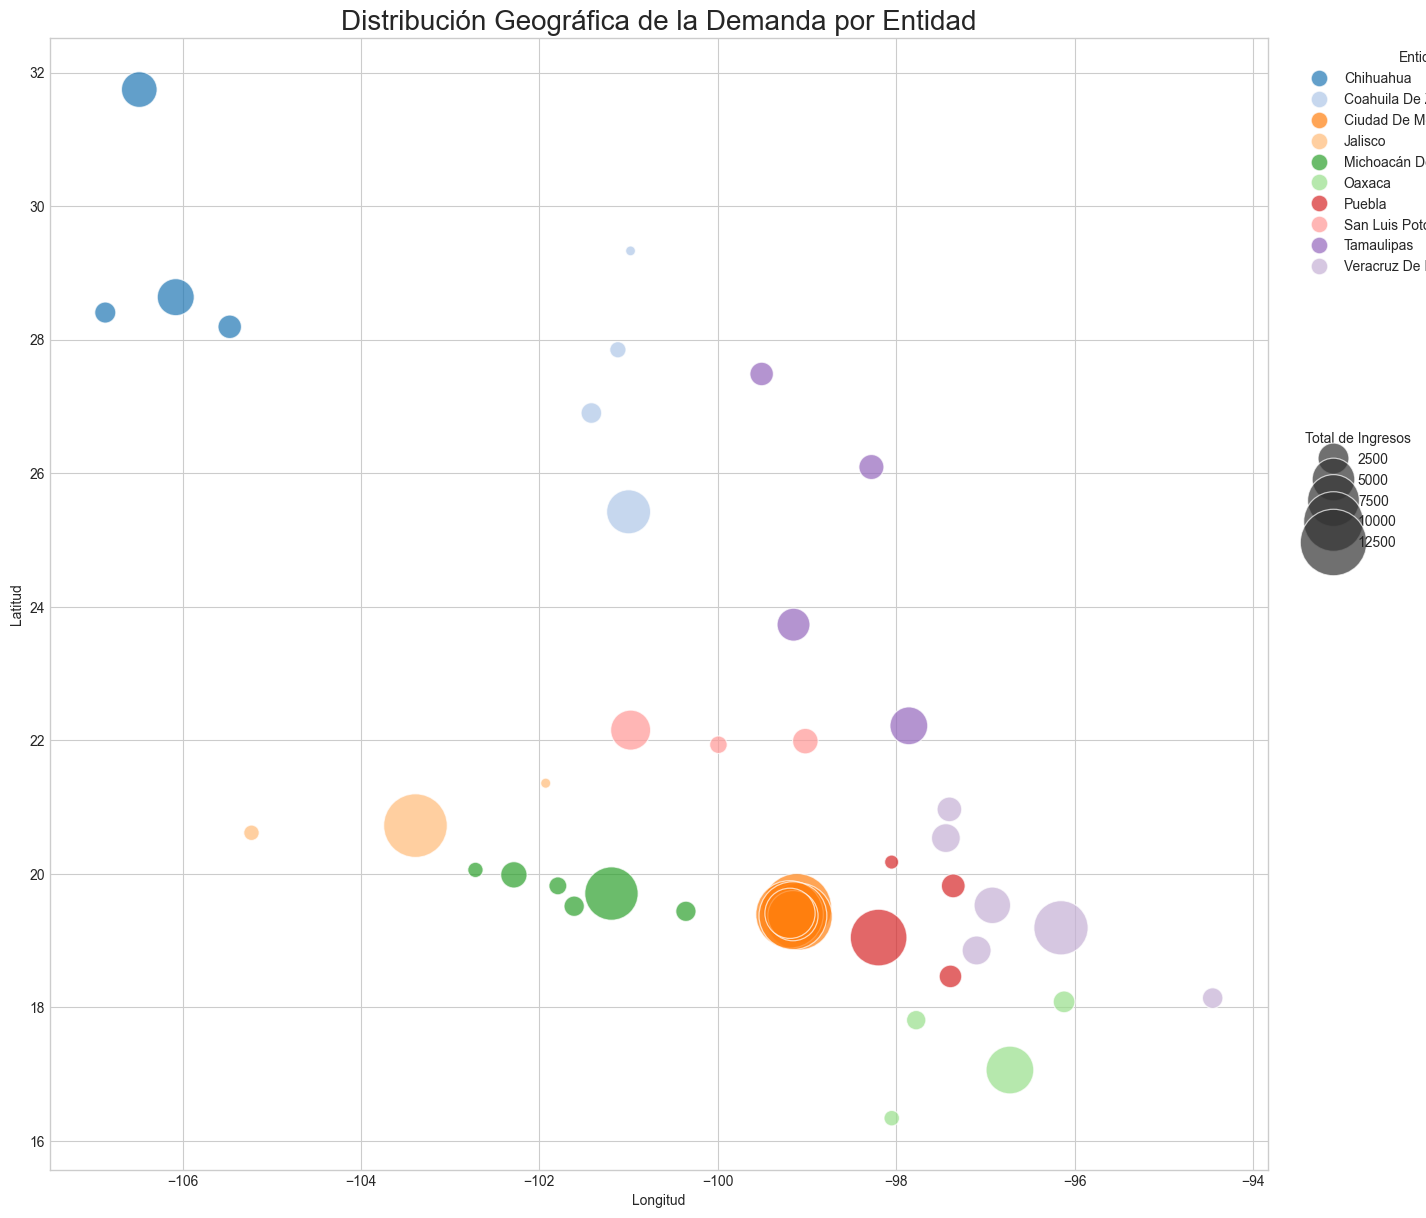

In [5]:
# Agrupamos por hospital (código sin cambios)
carga_por_hospital = df.groupby('clues').agg(
    lat_decimal=('lat_decimal', 'first'),
    lon_decimal=('lon_decimal', 'first'),
    total_ingresos=('clues', 'size'),
    nombre_entidad=('nombre_entidad', 'first')
).reset_index()

top_10_entidades = carga_por_hospital['nombre_entidad'].value_counts().nlargest(10).index
df_mapa_filtrado = carga_por_hospital[carga_por_hospital['nombre_entidad'].isin(top_10_entidades)]

# 1. Creamos la figura y el eje
fig, ax = plt.subplots(figsize=(18, 12))

# 2. Creamos el gráfico de dispersión
sns.scatterplot(
    data=df_mapa_filtrado,
    x='lon_decimal',
    y='lat_decimal',
    size='total_ingresos',
    sizes=(50, 2500),
    alpha=0.7,
    hue='nombre_entidad',
    palette='tab20',
    ax=ax
)

handles, labels = ax.get_legend_handles_labels()

try:
    size_legend_start_index = labels.index('total_ingresos')
    
    # Separamos y limpiamos los elementos de cada leyenda
    hue_handles = handles[1:size_legend_start_index]
    hue_labels = labels[1:size_legend_start_index]
    
    size_handles = handles[size_legend_start_index + 1:]
    size_labels = labels[size_legend_start_index + 1:]

    # Creamos la leyenda de entidades, AÑADIENDO fontsize='medium' o 'small'
    legend_entidades = ax.legend(hue_handles, hue_labels, title='Entidad', 
                                 bbox_to_anchor=(1.02, 1), loc='upper left', 
                                 markerscale=2.0, fontsize='medium')
    ax.add_artist(legend_entidades)

    # Creamos la leyenda de tamaños
    legend_tamano = ax.legend(size_handles, size_labels, title='Total de Ingresos', 
                              bbox_to_anchor=(1.02, 0.6), loc='center left', fontsize='medium')
except ValueError:
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', markerscale=2.5)

# Ajustamos el layout para evitar solapamientos
fig.tight_layout(rect=(0, 0, 0.8, 1))

ax.set_title('Distribución Geográfica de la Demanda por Entidad', fontsize=20)
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.grid(True)
plt.show()

## GeoPandas

In [ ]:
# Convertir el DataFrame de Pandas a un GeoDataFrame.
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon_decimal, df.lat_decimal), crs="EPSG:4326"
)
print(gdf.head())

   clave_entidad  clave_municipio  clave_localidad nombre_entidad  \
0             11                7                1     Guanajuato   
1             11                7                1     Guanajuato   
2             11                7                1     Guanajuato   
3             11                7                1     Guanajuato   
4             11                7                1     Guanajuato   

  nombre_municipio nombre_localidad  lat_decimal  lon_decimal    sexo  \
0           Celaya           Celaya    20.521523  -100.813573  hombre   
1           Celaya           Celaya    20.521523  -100.813573  hombre   
2           Celaya           Celaya    20.521523  -100.813573  hombre   
3           Celaya           Celaya    20.521523  -100.813573   mujer   
4           Celaya           Celaya    20.521523  -100.813573  hombre   

   servicio_troncal fecha_ingreso fecha_egreso diagnostico_principal_cie10  \
0         Pediatria    2024-01-26   2024-01-28                      

✅ Cargados 33 estados de México


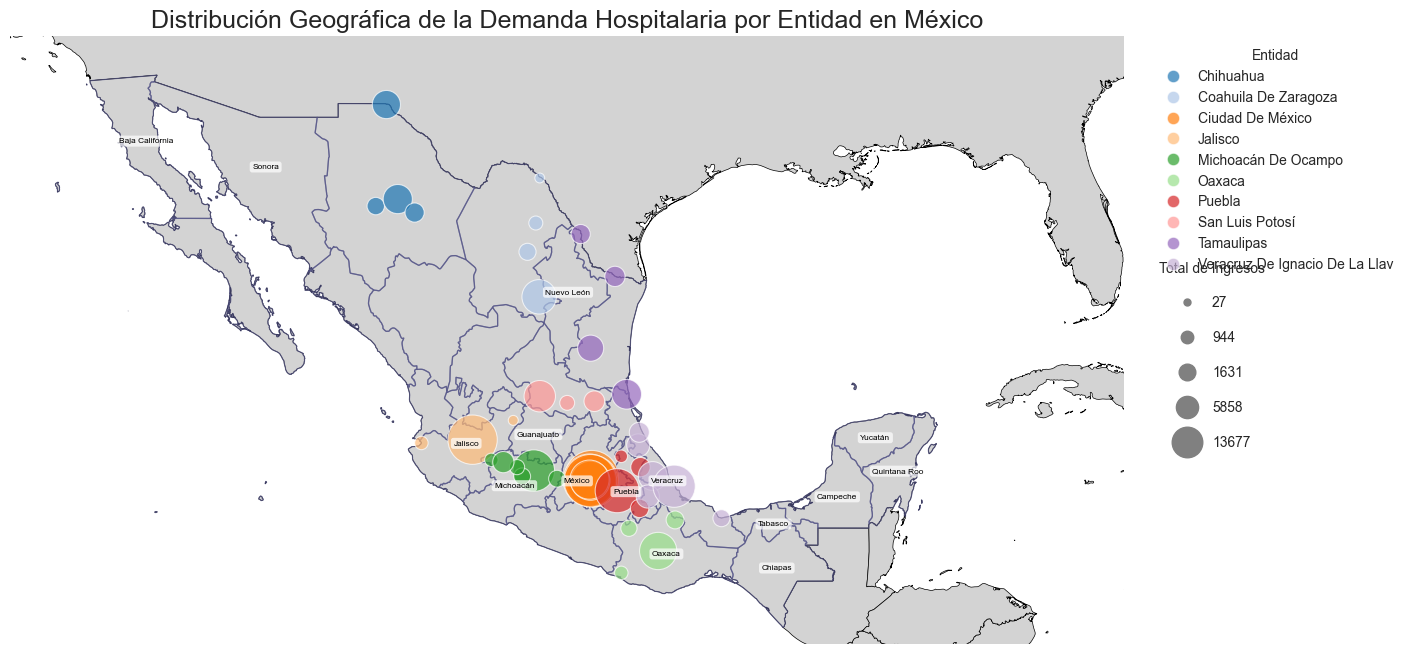

In [ ]:
# 1. Preparar datos
carga_por_hospital = df.groupby('clues').agg(
    lat_decimal=('lat_decimal', 'first'),
    lon_decimal=('lon_decimal', 'first'),
    total_ingresos=('clues', 'size'),
    nombre_entidad=('nombre_entidad', 'first')
).reset_index()

# Filtrar top 10 entidades
top_10_entidades = carga_por_hospital['nombre_entidad'].value_counts().nlargest(10).index
df_mapa_filtrado = carga_por_hospital[carga_por_hospital['nombre_entidad'].isin(top_10_entidades)]

# === 2. Cargar mapas base ===
# Fondo: países del mundo (baja resolución) — ¡eliminé el espacio al final!
world_countries = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_countries.zip"
)

# Fronteras detalladas de estados (alta resolución: 10m) — ¡eliminé el espacio al final!
states_url = "https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces.zip"
world_states = gpd.read_file(states_url)

# Filtrar solo los estados de México
mexico_states = world_states[world_states['admin'] == 'Mexico']

# Verificación
assert not mexico_states.empty, "❌ No se cargaron estados de México"
print(f"✅ Cargados {len(mexico_states)} estados de México")

# 3. Crear el gráfico
fig, ax = plt.subplots(figsize=(18, 12))

# Fondo: países de Norteamérica
world_countries[world_countries['CONTINENT'] == 'North America'].plot(
    ax=ax, color='lightgrey', edgecolor='black', linewidth=0.5
)

# SUPERPONER FRONTERAS DE ESTADOS DE MÉXICO
mexico_states.plot(
    ax=ax,
    facecolor='none',
    edgecolor='#555588',      
    linewidth=0.9,            
    alpha=0.7                 
)

# AGREGAR ETIQUETAS DE ESTADOS 
estados_a_mostrar = [
    'México', 'Jalisco', 'Nuevo León', 'Veracruz', 'Puebla',
    'Guanajuato', 'Michoacán', 'Chiapas', 'Sonora', 'Baja California',
    'Quintana Roo', 'Yucatán', 'Tabasco', 'Campeche', 'Oaxaca'
]

for idx, row in mexico_states.iterrows():
    if row['name'] not in estados_a_mostrar:
        continue  # Saltar si no está en la lista

    centroid = row.geometry.centroid
    x, y = centroid.x, centroid.y
    
    # Solo mostrar dentro del área principal
    if not (-118 < x < -82 and 16 < y < 32):
        continue
        
    nombre = row['name']
    
    ax.text(
        x, y, nombre,
        fontsize=6,
        ha='center', va='center',
        color='black',
        bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.7, edgecolor='none'),
        zorder=10
    )

# Recortar al área de interés (México)
ax.set_xlim((-120, -80))
ax.set_ylim((14, 34))

# 4. Graficar
sns.scatterplot(
    data=df_mapa_filtrado,
    x='lon_decimal',
    y='lat_decimal',
    size='total_ingresos',
    sizes=(50, 1500),
    alpha=0.7,
    hue='nombre_entidad',
    palette='tab20',
    ax=ax,
    legend='full'
)

# Eliminar leyenda automática de Seaborn
legend = ax.get_legend()
if legend:
    legend.remove()

# 5. Leyenda : Tamaño (Total de Ingresos)
size_legend_values = [27, 944, 1631, 5858, 13677]
size_legend_marker_sizes = [75, 135, 180, 240, 330]

size_handles_manual = []
for s_val, s_marker in zip(size_legend_values, size_legend_marker_sizes):
    size_handles_manual.append(
        Line2D([0], [0], marker='o', color='gray',
               markersize=s_marker / 15,
               label=str(s_val), linestyle='None')
    )

legend_tamano = ax.legend(
    size_handles_manual, [str(val) for val in size_legend_values],
    title='Total de Ingresos',
    bbox_to_anchor=(1.02, 0.65), loc='upper left',
    frameon=False, fontsize='medium', labelspacing=1.5
)
ax.add_artist(legend_tamano)

# 6. Leyenda: Entidad 
handles, labels = ax.get_legend_handles_labels()

try:
    hue_start = labels.index('nombre_entidad') + 1
    size_start = labels.index('total_ingresos')
    hue_handles = handles[hue_start:size_start]
    hue_labels = labels[hue_start:size_start]

    legend_entidades = ax.legend(
        hue_handles, hue_labels, title='Entidad',
        bbox_to_anchor=(1.02, 1.0), loc='upper left',
        markerscale=1.5, fontsize='medium', frameon=False
    )
except (ValueError, IndexError):
    unique_entidades = df_mapa_filtrado['nombre_entidad'].unique()
    colors = sns.color_palette('tab20', len(unique_entidades))
    fallback_handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8)
        for color in colors
    ]
    ax.legend(
        fallback_handles, unique_entidades, title='Entidad',
        bbox_to_anchor=(1.02, 1.0), loc='upper left',
        frameon=False
    )

fig.tight_layout(rect=(0, 0, 0.82, 1))
ax.set_title('Distribución Geográfica de la Demanda Hospitalaria por Entidad en México', fontsize=18)
ax.axis('off')

plt.show()